<a href="https://colab.research.google.com/github/benihime91/Covid-Waste-Detection/blob/main/IceVision_model_training_effdnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Covid 19 Waste Detection using [EfficientDet](https://github.com/rwightman/efficientdet-pytorch/blob/master/effdet/config/model_config.py)

To train we will use the [IceVision](https://github.com/airctic/icevision) Library.

<img src="https://github.com/airctic/icevision/blob/master/images/icevision-logo-slogan.png?raw=true" width="500">


This notebook builds upon this [tutorial](https://github.com/airctic/icevision/blob/master/notebooks/wandb_efficientdet.ipynb).


# Installing IceVision, IceData

In [ ]:
!pip install -Uqq git+git://github.com/airctic/icevision.git#egg=icevision[all]
!pip install -Uqq git+git://github.com/airctic/icedata.git

In [1]:
# Needs to restart runtime in Google Colab
# What GPU are we using?
!nvidia-smi

Sun May  9 12:50:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [2]:
import icedata
from icevision.all import *
from fastai.callback.tracker import SaveModelCallback

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:69


# Loading the Dataset

In [3]:
!unzip /content/drive/MyDrive/pascal-voc-waste-covid-19.zip -d /content/ > /dev/null

In [4]:
data_dir = Path("/content/pascal-voc-waste-covid-19/")

In [5]:
parser = parsers.VOCBBoxParser(data_dir/"train", data_dir/"train")
train_records, *_ = parser.parse(SingleSplitSplitter())

valid_parser =  parsers.VOCBBoxParser(data_dir/"test", data_dir/"test")
valid_records , *_ = valid_parser.parse(SingleSplitSplitter())

  0%|          | 0/189 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/189 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: 64) - Clipping bbox xmax from 1025 to image width 1024 (Before: <BBox (xmin:683, ymin:716, xmax:1025, ymax:950)>) | icevision.utils.logger_utils:autofix_log:17


  0%|          | 0/80 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/80 [00:00<?, ?it/s]

Let's check out the class map for our Dataset to ensure that all the classes are properly registerd -

In [6]:
parser.class_map, valid_parser.class_map

(<ClassMap: {'background': 0, 'syringe': 1, 'glove': 2, 'mask': 3}>,
 <ClassMap: {'background': 0, 'syringe': 1, 'glove': 2, 'mask': 3}>)

## Train and Validation Datasets

In [18]:
presize = 900
size = 512

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

len(train_ds), len(valid_ds)

(189, 80)

## Create the model
In IceVision, we need to select the model type and backbone. For this tutorial, we are selecting efficientdet and the `efficientdet-b3` backbone. Some models require additional information, such as the `image_size`.

In [34]:
# Library and model selection
model_type = models.ross.efficientdet
backbone = model_type.backbones.d0(pretrained=True)

# The efficientdet model requires an img_size parameter
extra_args = {'img_size' : size}

model = efficientdet.model(backbone=backbone, num_classes=len(parser.class_map), **extra_args)

## Create the dataloaders

In [36]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=20, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=5, shuffle=False)

Showing what's inside a batch

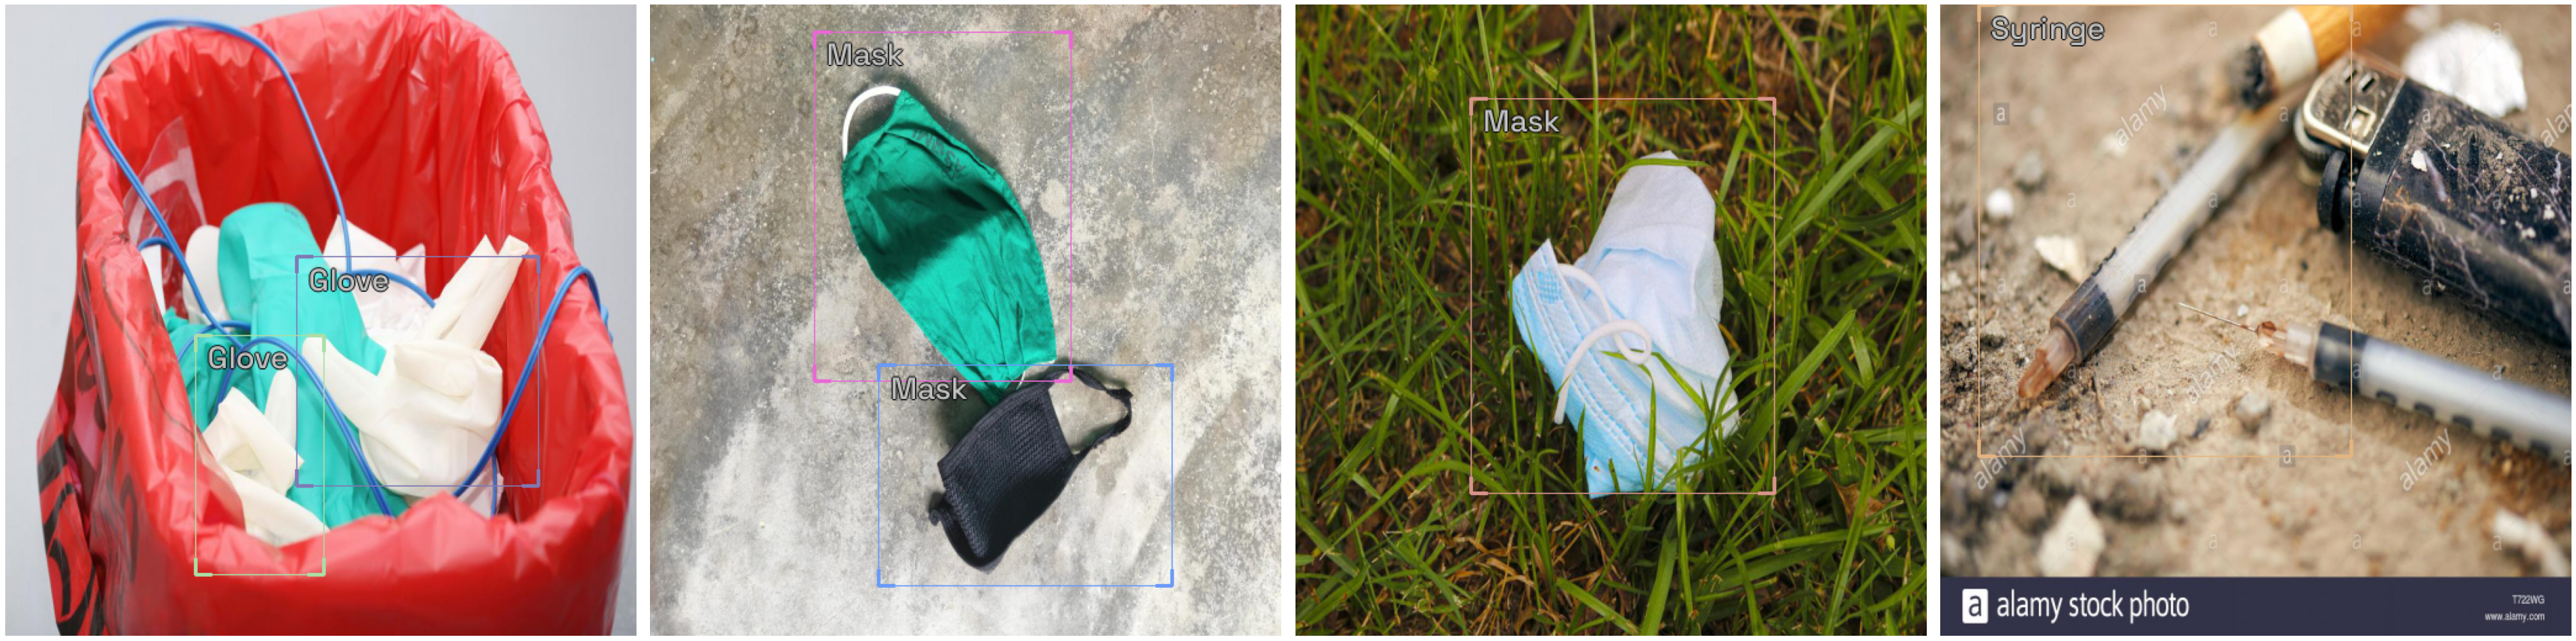

In [37]:
dl = model_type.valid_dl(valid_ds, batch_size=4, shuffle=True)
batch = first(dl)
model_type.show_batch(batch, ncols=4)

# Training a fastai Learner

In [39]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, 
                                  metrics=[COCOMetric(metric_type=COCOMetricType.bbox)])

In [23]:
# learn.lr_find()

In [41]:
learn.fit_flat_cos(60, 1e-04, pct_start=0.1)

# Showing training results

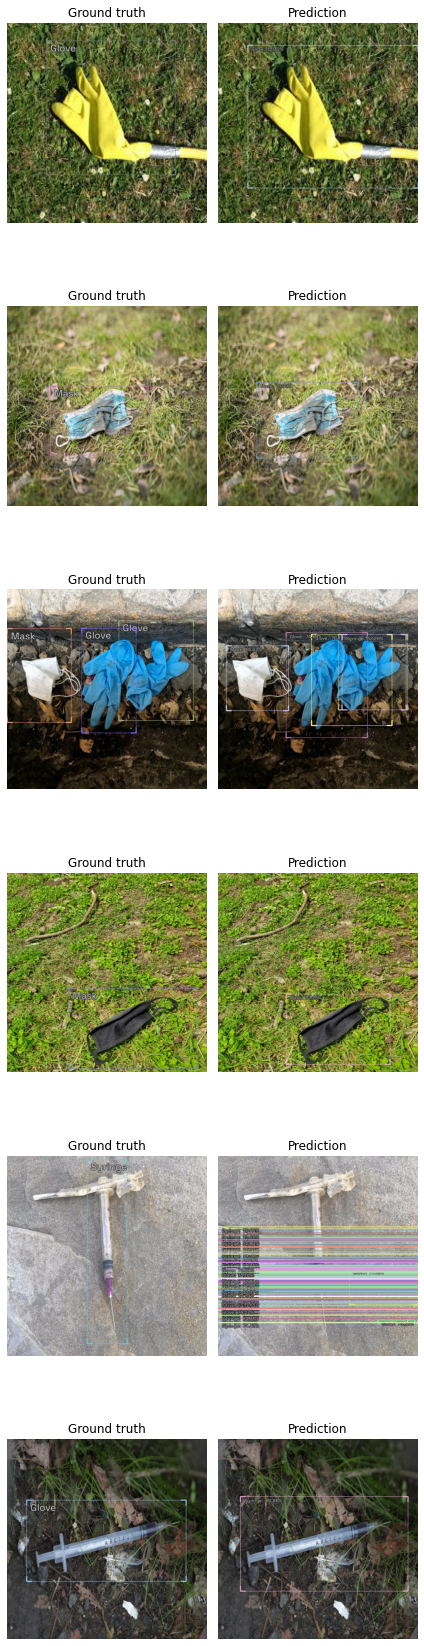

In [42]:
model_type.show_results(model, valid_ds, detection_threshold=0.5)

# Inference pipeline

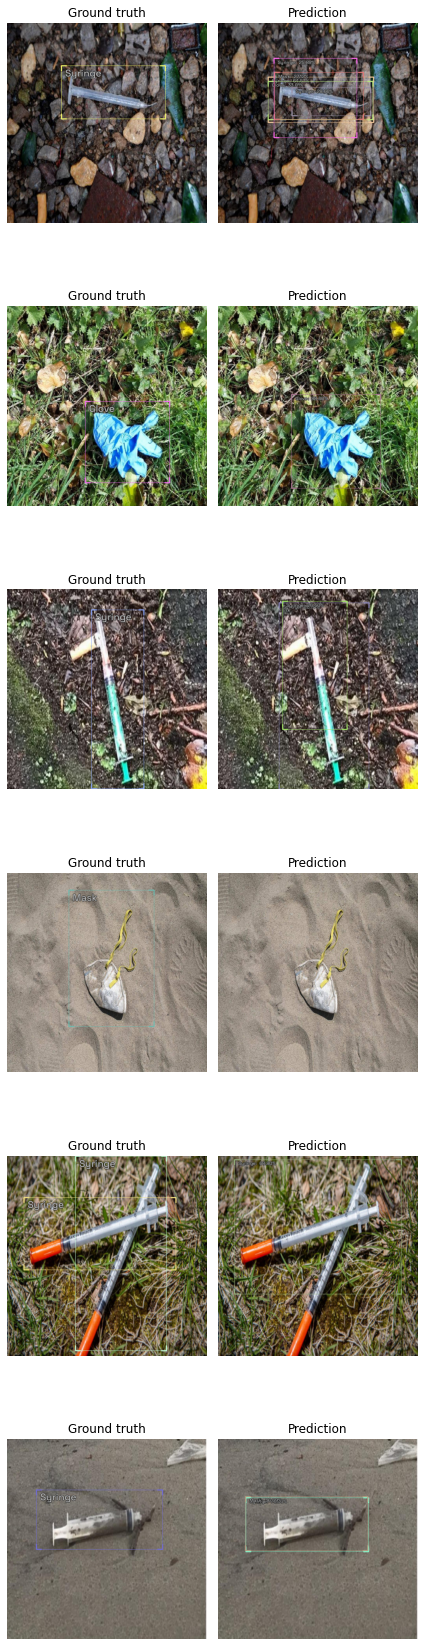

In [43]:
preds = model_type.predict(model, valid_ds, detection_threshold=0.25)

show_preds(preds=preds[:6], denormalize_fn=denormalize_imagenet, ncols=3,)

  0%|          | 0/80 [00:00<?, ?it/s]

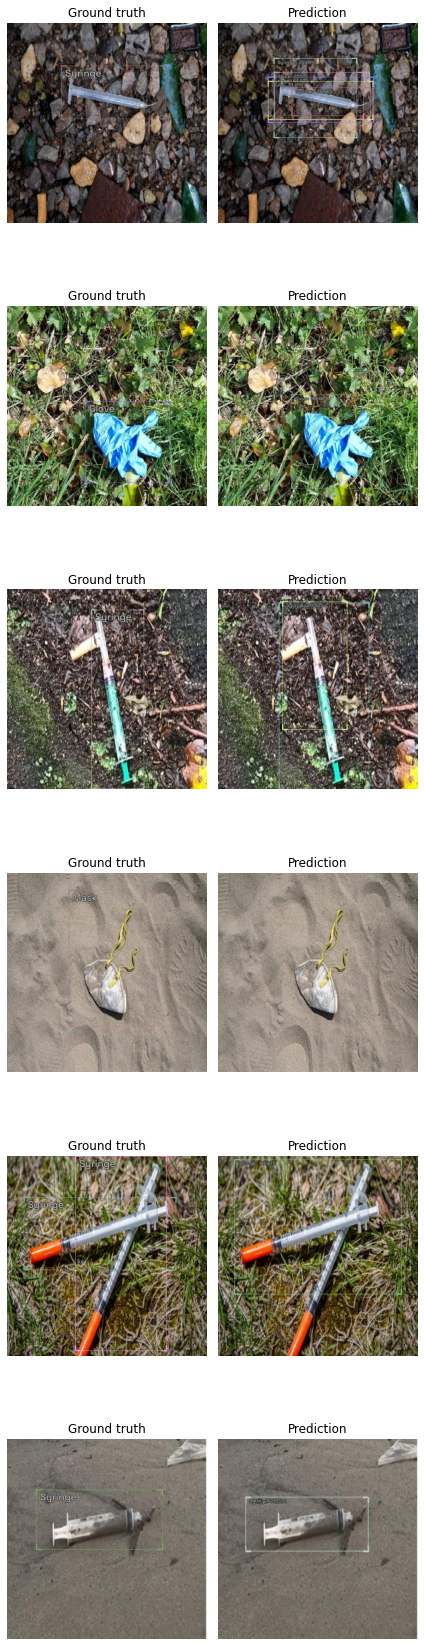

In [44]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=1, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, detection_threshold=0.25, keep_images=True)

show_preds(preds=preds[:6], denormalize_fn=denormalize_imagenet, ncols=3,)